In [1]:
from PIL import Image as im
import numpy as np
import math

In [2]:
def zoom(img, fold):
    newimg = im.new('RGB', (img.width*fold, img.height*fold))
    npixels = newimg.load()
    opixels = img.load()
    for i in range(0, newimg.width, fold):
        for j in range(0, newimg.height, fold):
            for a in range(i, i+fold):
                for b in range(j, j+fold):
                    npixels[a, b] = opixels[i/fold, j/fold]
    return newimg

In [3]:
def brightness(img, val):
    pixels = img.load()
    for i in range(img.width):
        for j in range(img.height):
            pixels[i,j] = (pixels[i,j][0] + val, pixels[i,j][1] + val, pixels[i,j][2] + val)
    return img

In [4]:
def enlarge(img):
    newimg = im.new( 'RGB', (2*img.width-1, 2*img.height-1))
    newpixels = newimg.load()
    pixels = img.load()
    
    for i in range(0, newimg.width, 2):
        for j in range(0, newimg.height, 2):
            newpixels[i,j] = pixels[i/2, j/2]
    
    return newimg

In [5]:
def fill(img):
    pixels = img.load()
    for i in range(0, img.width):
        for j in range(0, img.height):
            if i%2 == 1 and j%2 == 1:
                r = round((pixels[i-1, j-1][0] + pixels[i-1, j+1][0] + pixels[i+1, j-1][0] + pixels[i+1, j+1][0])/4)
                g = round((pixels[i-1, j-1][1] + pixels[i-1, j+1][1] + pixels[i+1, j-1][1] + pixels[i+1, j+1][1])/4)
                b = round((pixels[i-1, j-1][2] + pixels[i-1, j+1][2] + pixels[i+1, j-1][2] + pixels[i+1, j+1][2])/4)
                pixels[i,j] = (r, g, b)
            elif i%2 == 0 and j%2 == 1:
                r = round((pixels[i, j-1][0] + pixels[i, j+1][0])/2)
                g = round((pixels[i, j-1][1] + pixels[i, j+1][1])/2)
                b = round((pixels[i, j-1][2] + pixels[i, j+1][2])/2)
                pixels[i,j] = (r, g, b)
            elif i%2 == 1 and j%2 == 0:
                r = round((pixels[i-1, j][0] + pixels[i+1, j][0])/2)
                g = round((pixels[i-1, j][1] + pixels[i+1, j][1])/2)
                b = round((pixels[i-1, j][2] + pixels[i+1, j][2])/2)
                pixels[i,j] = (r, g, b)
    return img

In [6]:
def rotate(matrix):
    h = len(matrix)
    w = len(matrix[0])
    
    for i in range(w):
        for j in range(round(h/2)):
            temp = matrix[j][i]
            matrix[j][i] = matrix[h-j-1][i]
            matrix[h-j-1][i] = temp
    
    for i in range(h):
        for j in range(round(w/2)):
            temp = matrix[i][j]
            matrix[i][j] = matrix[i][w-j-1]
            matrix[i][w-j-1] = temp
    
    return matrix

In [10]:
# FILTERS

#identity
birim_filt = [[0,0,0],
        [0,1,0],
        [0,0,0]]

#edge detection
edge_filt1 = [[1,0,-1],
        [0,0,0],
        [-1,0,1]]

edge_filt2 = [[0,1,0],
        [1,-4,1],
        [0,1,0]]

edge_filt3 = [[-1,-1,-1],
        [-1,8,-1],
        [-1,-1,-1]]

#sharpen
filt5 = [[0,-1,0],
        [-1,5,-1],
        [0,-1,0]]

#box-blur
filt6 = prepare_filter(3)

#gaussian blur 3x3
gaussianblur3_filt = [[1,2,1],
        [2,4,2],
        [1,2,1]]
filt7 = np.multiply(gaussianblur3_filt, 1/16)

#gaussian blur 5x5
gaussianblur5_filt = [
    [1,4,6,4,1],
    [4,16,24,16,4],
    [6,24,36,24,6],
    [4,16,24,16,4],
    [1,4,6,4,1],
]
filt8 = np.multiply(gaussianblur5_filt, 1/256)

#unsharp masking 5x5
unsharp_filt = [
    [1,4,6,4,1],
    [4,16,24,16,4],
    [6,24,-476,24,6],
    [4,16,24,16,4],
    [1,4,6,4,1],
]
filt9 = np.multiply(unsharp_filt, 1/256)

#keskinlestirme filtresi
filtre_keskinlestirme = [
    [0,-2,0],
    [-2,11,-2],
    [0,-2,0]
]

In [7]:
def prepare_filter(n):
    cell = 1/math.pow(n, 2)
    
    filt = []
    for i in range(n):
        filt.append([])
        for j in range(n):
            filt[i].append(cell)
    
    return filt

In [8]:
def normalize(val):
    if val > 255:
        val = 255
    elif val < 0:
        val = 0
    return math.floor(val)

In [9]:
def filtrele(img, filt):
    pixels = img.load()
    newimg = im.new('RGB', (img.width, img.height))
    newpixels = newimg.load()
    
    filt = rotate(filt)
    filt_total = np.sum(filt)
    filt_hh = math.floor(len(filt)/2) #half height
    filt_hw = math.floor(len(filt[0])/2) #half width
    if filt_total == 0:
        filt_total = 1
    
    for i in range(img.height-filt_hh):
        for j in range(img.width-filt_hw):
            tempr = 0
            tempg = 0
            tempb = 0
            for a in range(len(filt)):
                for b in range(len(filt[0])):
                    tempr = tempr + pixels[j-filt_hw+b, i-filt_hh+a][0] * filt[a][b]
                    tempg = tempg + pixels[j-filt_hw+b, i-filt_hh+a][1] * filt[a][b]
                    tempb = tempb + pixels[j-filt_hw+b, i-filt_hh+a][2] * filt[a][b]
                    
            tempr = tempr/filt_total
            tempg = tempg/filt_total
            tempb = tempb/filt_total
            
            newpixels[j, i] = (normalize(tempr), normalize(tempg), normalize(tempb))
    
    return newimg

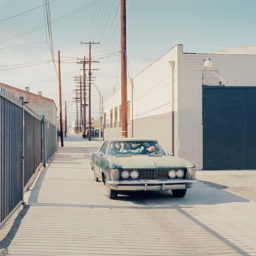

In [15]:
image = im.open('resim.jpg')
image

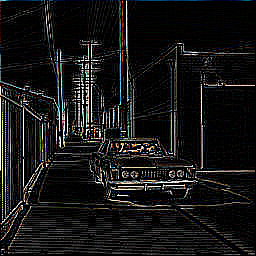

In [16]:
conv = filtrele(image, edge_filt3)
conv

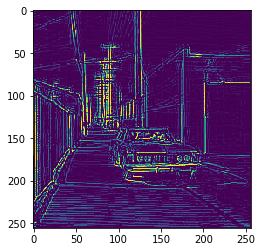

In [18]:
from matplotlib import pyplot as plt
plt.imshow(conv.convert('L'))